In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import date

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [5]:
engine = create_engine("sqlite:///../resources/hawaii.sqlite")

In [6]:
# Declare a Base using `automap_base()`
Base = automap_base()


In [7]:
# reflect an existing database into a new model
Base.prepare(engine, reflect=True)
# reflect the tables

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)
#using sqlalchemy inspect to list table names and column names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
#note: tobs = "temperature observed"

columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

### Design a query to retrieve the last 12 months of precipitation data and plot the results

   * Calculate the date 1 year ago from the last data point in the database

   * Perform a query to retrieve the data and precipitation scores

   * Save the query results as a Pandas DataFrame and set the index to the date column

   * Sort the dataframe by date

   * Use Pandas Plotting with Matplotlib to plot the data


In [13]:
#  Calculate the date 1 year ago from the last data point in the database
    # use func to get the last data point in Measurement as a str and convert to dt.date type
max_date = dt.date.fromisoformat(
    session.query(
    func.max(Measurement.date)
                 ).all()[0][0])


In [14]:
#use date.replace to subtract one year and make it back into a str
start_date = max_date.replace(year=max_date.year-1).isoformat()
print(f'{start_date} thru {max_date}')

2016-08-23 thru 2017-08-23


In [15]:
# Perform a query to retrieve the data and precipitation scores
result = session.query(Measurement.date, Measurement.prcp) \
                .filter(Measurement.date >= start_date)    \
                .order_by(Measurement.date.desc())
                      


In [16]:
#   Save the query results as a Pandas DataFrame and set the index to the date column  
df = pd.read_sql(result.statement, result.session.bind)
df.set_index('date', inplace=True)
df.sort_values('date', inplace=True)


df.head()

,prcp
date,
2016-08-23,0.70
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,1.79
2016-08-23,NaN


In [17]:
        # Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()  #cf, grouped by date below

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
#NOTE: The precipitation analysis requirements specifically say 
#      only get prcp and date columns, so not breaking out by station
#      grouping by date with sum() to get total prcp across all stations

df_by_date = df.groupby("date").sum()
df_by_date.describe()


,prcp
count,366.000000
mean,0.978907
std,1.776349
min,0.000000
25%,0.052500
50%,0.405000
75%,1.087500
max,14.280000


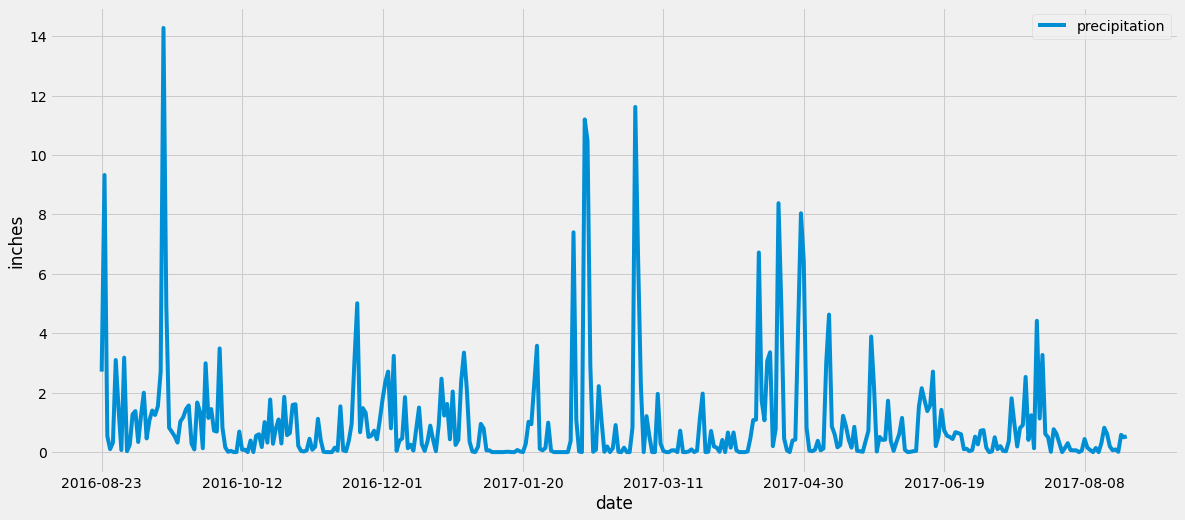

In [19]:
# Use Pandas Plotting with Matplotlib to plot the data
rename_dct = {'prcp':'precipitation'}

df_by_date.rename(columns = rename_dct, inplace=True)

subplot = df_by_date.plot(figsize=(18, 8))
subplot.set_ylabel("inches")
plt.savefig('Saved Precip Trend.png')

In [20]:
# Design a query to show how many stations are available in this dataset
    #note: I am not filtering by date b/c the requirement is for this dataset, 
    #as opposed to just the final 12 months of measurements
conn = engine.connect()
stmt = "SELECT * FROM station"
df_stations = pd.read_sql(stmt, conn)
df_stations

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [21]:
print(df_stations.nunique())

id           9
station      9
name         9
latitude     9
longitude    9
elevation    9
dtype: int64


* 9 distinct stations found in dataset.

In [22]:
# confirm count with measurement table
stmt = "SELECT * FROM measurement"
df_measurement = pd.read_sql(stmt, conn)
print(df_measurement.nunique())

id         19550
station        9
date        2792
prcp         342
tobs          35
dtype: int64


In [23]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

# approach 1: 
print(df_measurement['station'].value_counts())
    # Prints counts in descending order during test, but not sure if that is always the case.

USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838     511
Name: station, dtype: int64


In [24]:
# approach 2: session query. 

agg_col_name = "measurement_count"

station_counts =session.query(Station.name \
                            , func.count(Measurement.prcp) \
                            .label(agg_col_name)) \
                            .filter(Measurement.station == Station.station) \
                            .group_by(Measurement.station) \
                            .order_by(agg_col_name)


#####*****#####    This works, too. isouter=True makes it a left join, False would be inner: #####*****#####
# station_counts =session.query(Station.name \
#                             , func.count(Measurement.prcp) \
#                             .label(agg_col_name)) \
#                             .join(Station, Measurement.station == Station.station, isouter=True) \
#                             .group_by(Measurement.station)
#                             .order_by(agg_col_name)

#note: I spent a good amount of time trying to get the order by... DESC into the query. 
# After several attempts, I decided to sort the aggregate measure in the
# dataframe
df_active_stations = pd.read_sql(station_counts.statement, conn)
df_active_stations.sort_values(by=agg_col_name, ascending=False)


,name,measurement_count
8,"WAIHEE 837.5, HI US",2772
7,"KANEOHE 838.1, HI US",2696
6,"WAIKIKI 717.2, HI US",2685
5,"WAIMANALO EXPERIMENTAL FARM, HI US",2572
4,"MANOA LYON ARBO 785.2, HI US",2484
3,"KUALOA RANCH HEADQUARTERS 886.9, HI US",1937
2,"HONOLULU OBSERVATORY 702.2, HI US",1932
1,"PEARL CITY, HI US",683
0,"UPPER WAHIAWA 874.3, HI US",342


In [26]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

# method1: longhand SQL
stmt = "SELECT min(tobs) min_temp, max(tobs) max_temp, avg(tobs) avg_temp FROM measurement WHERE station='USC00519281'"
df_temp_summary = pd.read_sql(stmt, conn)
df_temp_summary.head()

,min_temp,max_temp,avg_temp
0,54.0,85.0,71.663781


In [27]:
#method 2: session.query
station_id = "USC00519281"

temperature_aggs = session.query (func.min(Measurement.tobs).label("min_temp")
                                 ,func.max(Measurement.tobs).label("max_temp")
                                 ,func.avg(Measurement.tobs).label("avg_temp")
                                ).filter(Measurement.station==station_id)

df_temp_stats = pd.read_sql(temperature_aggs.statement, conn)
df_temp_stats

,min_temp,max_temp,avg_temp
0,54.0,85.0,71.663781


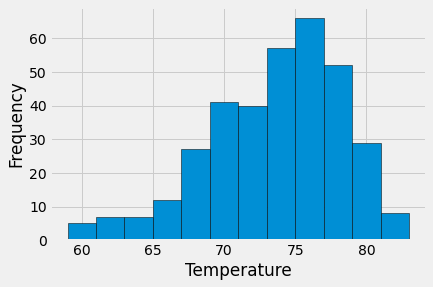

In [29]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_hist = session.query(Measurement.tobs) \
            .filter(Measurement.station==station_id) \
            .filter(Measurement.date > start_date) #start_date was derived above at the first step in climate analysis

df_temp_hist = pd.read_sql(temp_hist.statement, conn)

plt.hist(df_temp_hist.tobs, bins=12, ec="black")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
# Save image just for practice
plt.savefig('saved_temp_histogram.png')
plt.show()

## Bonus Challenge Assignment

In [53]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
temp_summary = calc_temps("2012-02-28", "2012-03-05")


In [56]:
print(f'Lowest temperature: {temp_summary[0][0]:,.2f}, highest temperature: {temp_summary[0][2]:,.2f}, Average Temperature:{temp_summary[0][1]:,.2f} ')

Lowest temperature: 62.00, highest temperature: 74.00, Average Temperature:69.57 


In [52]:
print(temp_summary)

(62.0, 69.57142857142857, 74.0)


In [27]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [28]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [29]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [30]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [31]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [32]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [33]:
# Plot the daily normals as an area plot with `stacked=False`
